<a href="https://colab.research.google.com/github/FrozenPeak0701/MusicCopilotGPT/blob/main/suzukireproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L
!lscpu |grep 'Model name'

GPU 0: Tesla T4 (UUID: GPU-03678ca8-c3aa-de1b-627f-3d5af11d4d2f)
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz


In [2]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls gdrive/MyDrive/Data/

ATEPP-1.1      detokenizer  requirements.txt	   tokenizer
convert.json   musicXml     sample.py		   tokenProduction.ipynb
CreateCsv.py   mxl	    test.ipynb
CSV	       __pycache__  tokenized_files
dataloader.py  remi	    tokenized_scores.json


In [4]:
data_dir = "gdrive/MyDrive/Data/"

In [5]:
!pip install -r "{data_dir}requirements.txt"
!pip install miditoolkit

In [6]:
import sys
sys.path.append(data_dir)

In [56]:
from dataloader import *
import pandas as pd
from remi import *
import miditoolkit
from tokenizer.score_to_tokens import *
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import json
import pickle
from torch.utils.data import Subset
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [57]:
torch.cuda.memory_allocated()

34376704

In [58]:
tokenized_file_dir = 'tokenized_files/'
dataset = CustomTokenDataset(f'{data_dir}CSV/data.csv')
tmp = dataset[0]

indices = list(range(len(dataset)))
td = [310, 308, 307, 306, 305, 304, 282, 280, 279, 278, 276, 264, 263, 256, 245, 242, 220, 213, 212, 211, 209, 207, 203, 196, 194, 193, 192, 191, 190, 186, 184, 182, 181 ,178, 177, 175, 174, 169, 66, 48, 33, 28, 27, 24]
for i in td:
  del indices[i]

new_dataset = Subset(dataset, indices)
len(new_dataset)

275

In [59]:
# tokenized_scores_list = ['sos', 'eos']
# max_midi_token_len = 0
# max_score_token_len = 0
# files = []
# for i,dat in enumerate(new_dataset):
#   print(f"{i + len(td)}|", end = '')
#   try:
#     midi_obj = miditoolkit.midi.parser.MidiFile(data_dir+dat[2])
#     if len(midi_obj.instruments) == 2:
#       if (midi_obj.instruments[0].name!="Piano") or ((midi_obj.instruments[1].name!="Piano")):
#         print(f"{i}th object's midi file isn't 2 pianos: {midi_obj.instruments[0].name}, {midi_obj.instruments[1].name}")
#       else:
#         print(f"{i}th object's midi file is 2 pianos")
#     elif len(midi_obj.instruments) == 1:
#       print(f"{i}th object's midi file is 1 piano: {midi_obj.instruments[0].name}")
#     else:
#       print(f"{i}th object's midi file is more than two piano: {[i.name for i in midi_obj.instruments]}")
#     max_midi_token_len = max(*[len(i.notes) for i in midi_obj.instruments], max_midi_token_len)
#     scoretokens = MusicXML_to_tokens(data_dir+dat[1])
#     for tokj in scoretokens:
#         if (tokj not in tokenized_scores_list):
#           tokenized_scores_list.append(tokj)
#     max_score_token_len = max(max_score_token_len, len(scoretokens))
#     files.append(dat[0])
#   except (TypeError, FileNotFoundError, AttributeError) as e:
#     print(f"{e}")
# with open(data_dir+tokenized_file_dir+'correspondance.json', 'w') as f:
#     json.dump(files, f)
# tokenized_scores_list, max_score_token_len, max_midi_token_len

In [60]:
# with open(data_dir+'tokenized_scores.json', 'w') as f:
#     json.dump(tokenized_scores_list, f)

with open(data_dir+'tokenized_scores.json') as f:
    tokenized_scores_list = json.load(f)

In [61]:
len(tokenized_scores_list)

422

In [62]:
def normalize(value, length):
    return value / length

def encode(note, song_length):
    start_token = int(normalize(note.start, song_length) * 100)
    end_token = int(normalize(note.end, song_length) * 100)
    pitch_token = note.pitch
    velocity_token = note.velocity
    return [start_token, end_token, pitch_token, velocity_token]

In [63]:
# for i, dat in enumerate(new_dataset):
#   song = miditoolkit.midi.parser.MidiFile(data_dir+dat[2])
#   song_length = song.max_tick
#   dnotes = sorted([j for i in song.instruments for j in i.notes], key=lambda note: note.start)
#   tokens = [encode(note, song_length) for note in dnotes ]
#   with open(data_dir + tokenized_file_dir+f'midi{i}.pkl', 'wb') as f:
#     pickle.dump(tokens, f)

In [64]:
# with open(data_dir + tokenized_file_dir+'midi1.pkl', 'rb') as f:
#     tokens = pickle.load(f)
# tokens

In [65]:
# Create a mapping from tokens to integers
token_to_int = {token: i for i, token in enumerate(tokenized_scores_list)}

# Create a mapping from integers to tokens
int_to_token = {i: token for token, i in token_to_int.items()}

def token2intlist(tokens):
  return [token_to_int[i] for i in tokens]
def int2tokenlist(ints):
  return [int_to_token[i] for i in ints]

In [66]:
# for i, dat in enumerate(new_dataset):
#   strlist = MusicXML_to_tokens(data_dir+dat[1])
#   strlist = ['sos',] + strlist + ['eos',]
#   tokens = token2intlist(strlist)
#   with open(data_dir + tokenized_file_dir+f'score{i}.pkl', 'wb') as f:
#     pickle.dump(tokens, f)

In [67]:
# with open(data_dir + tokenized_file_dir+f'score0.pkl', 'rb') as f:
#     tokens = pickle.load(f)
# tokens

In [68]:
srcr = []
tgtr = []
max_src_len = 0
max_tgt_len = 0
for i in range(275):
  with open(data_dir + tokenized_file_dir+f'score{i}.pkl', 'rb') as f:
      tok = pickle.load(f)
      max_tgt_len = max(max_tgt_len, len(tok))
      tgtr.append(tok)

  with open(data_dir + tokenized_file_dir+f'midi{i}.pkl', 'rb') as f:
      tok = pickle.load(f)
      max_src_len = max(max_src_len, len(tok))
      srcr.append(tok)
len(srcr), len(tgtr), max_src_len, max_tgt_len

(275, 275, 10188, 35382)

In [69]:
len(tgtr[0]), len(srcr[0])

(4976, 1288)

In [70]:
def filterbysrclen(srcr, tgtr, n):
  # Pair the lists together and sort them by both elements
  paired_list = sorted([(len(a), len(b), a, b) for a, b in zip(srcr, tgtr)])

  # Initialize variables to track the pairs that meet the condition
  output_a = []
  output_b = []
  a_threshold = b_threshold = 0

  # Iterate through the sorted pairs and collect the first n that meet the condition
  max_a = 0
  max_b = 0
  for i, (a, b,c,d) in enumerate(paired_list):
      if i >= n:
          break
      output_a.append(c)
      output_b.append(d)
      max_a = max(max_a, a)
      max_b = max(max_b, b)

  return output_a, output_b, max_a, max_b

In [71]:
filtering = 100
a, b, c, d = filterbysrclen(srcr, tgtr, filtering)
len(a), len(b), c, d

(100, 100, 1655, 7779)

In [72]:
class MusicDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]

def pad_sequences(batch, padding_value=-1, feature_size = None):
    # Get sequence lengths
    lengths = [len(seq) for seq in batch]

    # Create an empty tensor with size of the longest sequence
    max_length = max(lengths)
    if feature_size is None:
      padded_batch = torch.full((len(batch), max_length), padding_value)
    else:
      padded_batch = torch.full((len(batch), max_length, feature_size), padding_value)

    # Pad the sequences
    for i, seq in enumerate(batch):
        padded_batch[i, :lengths[i]] = seq

    return padded_batch

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    src_batch = pad_sequences([torch.tensor(data) for data in src_batch],feature_size = 4)
    tgt_batch = pad_sequences([torch.tensor(data) for data in tgt_batch])

    return src_batch, tgt_batch

dataset = MusicDataset(a, b)

dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn, shuffle = True)  #

In [73]:
class Transformer(nn.Module):
    def __init__(self, embedding_size, num_heads, hidden_dim, num_layers, dropout, device, max_src_length=1700, max_tgt_length = 8000):
        super().__init__()

        self.device = device

        self.src_linear = nn.Linear(4, embedding_size)
        self.tgt_linear = nn.Linear(1, embedding_size)
        self.src_pos_embedding = nn.Embedding(max_src_length, embedding_size)
        self.tgt_pos_embedding = nn.Embedding(max_tgt_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_size, num_heads, hidden_dim, dropout),
            num_layers
        )

        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(embedding_size, num_heads, hidden_dim, dropout),
            num_layers
        )

        self.fc = nn.Linear(embedding_size, 1)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, src, tgt):
      src_mask = (src.sum(dim=-1) == -4)
      tgt_mask = (tgt == -1)
      # print(src_mask,tgt_mask, sep = '\n')
      # # This line ensures that the `inf` values do not result in NaN values after softmax
      # src_mask = src_mask.masked_fill(src_mask, sys.float_info.min)
      # tgt_mask = tgt_mask.masked_fill(tgt_mask, sys.float_info.min)
      # print(src_mask,tgt_mask, sep ='\n')
      return src_mask, tgt_mask


    def forward(self, src, tgt):
      # print(1,torch.cuda.memory_allocated()*1e-9)
      src = src.float()
      tgt = tgt.float()

      batch_size, src_seq_len, _ = src.size()
      _, tgt_seq_len = tgt.size()  # get sequence length of tgt
      # print(2,torch.cuda.memory_allocated()*1e-9)
      src_mask, tgt_mask = self.create_mask(src, tgt)

      # print(src_mask.shape, tgt_mask.shape,torch.cuda.memory_allocated()*1e-9)

      pos = (torch.arange(0, src_seq_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)).long()
      tgt_pos = (torch.arange(0, tgt_seq_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)).long()  # pos for tgt
      # print(pos.shape, tgt_pos.shape)
      # print(3,torch.cuda.memory_allocated()*1e-9)
      # print((self.src_linear(src) + self.src_pos_embedding(pos)).shape, (self.tgt_linear(tgt.unsqueeze(-1)) + self.tgt_pos_embedding(tgt_pos)).shape)
      src_embedded = self.dropout((self.src_linear(src) + self.src_pos_embedding(pos)).permute(1,0,2))
      tgt_embedded = self.dropout((self.tgt_linear(tgt.unsqueeze(-1)) + self.tgt_pos_embedding(tgt_pos)).permute(1,0,2))

      # print(4,torch.cuda.memory_allocated()*1e-9)
      # print(src_mask.shape, tgt_mask.shape, src_embedded.shape, tgt_embedded.shape)
      enc_src = self.encoder(src_embedded, src_key_padding_mask=src_mask)
      # print(5,torch.cuda.memory_allocated()*1e-9)
      # print(src_mask, tgt_mask, src_mask.shape, tgt_mask.shape)
      # print(enc_src.shape)
      output = self.decoder(tgt_embedded, enc_src, tgt_key_padding_mask=tgt_mask, memory_key_padding_mask=src_mask)
      # print(6,torch.cuda.memory_allocated()*1e-9)
      return self.fc(output.permute(1, 0, 2))

In [85]:
# Initialize model
embedding_size = 32
num_heads = 4
hidden_dim = 64
num_layers = 2
dropout = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(embedding_size, num_heads, hidden_dim, num_layers, dropout, device).to(device)

# Initialize optimizer and loss function
learning_rate = 5e-3
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.MSELoss()

In [86]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 353,409 trainable parameters


In [87]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for i, (src, tgt) in enumerate(dataloader):
      # if i==0:
        # Send your batch to the correct device
        # torch.cuda.empty_cache()

        optimizer.zero_grad()
        src = src.to(device).float()
        tgt = tgt.to(device).float()

        # print('src shape and tgt shape:',src.shape,tgt.shape)
        # Pass data through model
        output = model(src, tgt)

        # print(output, output.shape, tgt.shape)
        # Compute loss
        loss = criterion(output.squeeze(-1), tgt)
        # print(7, torch.cuda.memory_allocated()*1e-9)
        # Backward pass and optimization

        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        if i % 20 == 0:
            print(f'| Step [{i+1}/{len(dataloader)}], Loss: {loss.detach().item()}')
    train_losses.append(epoch_loss/len(dataloader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}')
    model.eval()
    val_loss = 0
    # someday
# Save model
# torch.save(model.state_dict(), "transformer_model.pt")

| Step [1/100], Loss: 5763.55517578125
| Step [21/100], Loss: 4656.8154296875
| Step [41/100], Loss: 3767.9931640625
| Step [61/100], Loss: 1352.0927734375
| Step [81/100], Loss: 2192.08203125
Epoch [1/10], Loss: 2301.224814453125
| Step [1/100], Loss: 973.6448974609375
| Step [21/100], Loss: 2499.813232421875
| Step [41/100], Loss: 975.5869750976562
| Step [61/100], Loss: 806.7142944335938
| Step [81/100], Loss: 1723.2607421875
Epoch [2/10], Loss: 1421.0910635375976
| Step [1/100], Loss: 2972.60205078125
| Step [21/100], Loss: 2082.11962890625
| Step [41/100], Loss: 2501.923095703125
| Step [61/100], Loss: 1332.520751953125
| Step [81/100], Loss: 1011.4954833984375
Epoch [3/10], Loss: 1351.8677951049804
| Step [1/100], Loss: 2174.53759765625
| Step [21/100], Loss: 918.088134765625
| Step [41/100], Loss: 977.6138305664062
| Step [61/100], Loss: 676.6741943359375
| Step [81/100], Loss: 1956.4774169921875
Epoch [4/10], Loss: 933.9577639770508
| Step [1/100], Loss: 683.7156982421875
| Ste

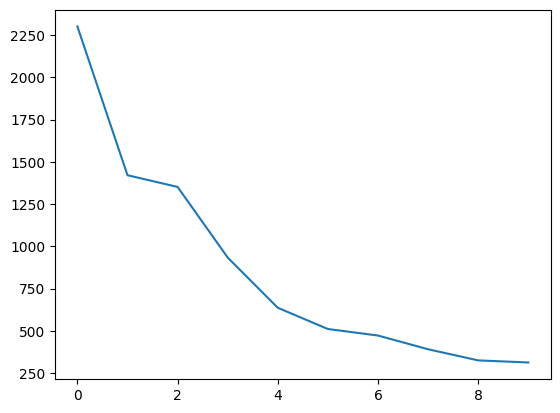

In [88]:
plt.plot(train_losses)

In [46]:
model

Transformer(
  (src_linear): Linear(in_features=4, out_features=32, bias=True)
  (tgt_linear): Linear(in_features=1, out_features=32, bias=True)
  (src_pos_embedding): Embedding(1700, 32)
  (tgt_pos_embedding): Embedding(8000, 32)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 